In [1]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import ceil
import numpy as np
import cv2
import os.path
#%load_ext tensorboard
#%matplotlib inline

In [3]:
!python3 --version

Python 3.5.3


In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.config.list_physical_devices('GPU'))

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def plot_history(history):
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [4]:
#current_dir = '/home/jakobkallestad'
current_dir = '/home/jupyter'
top_layers_checkpoint_path = current_dir + '/best_models_cifar10/top_layers_best.hdf5'
fine_tuned_checkpoint_path = current_dir + '/best_models_cifar10/fine_tuned_best.hdf5'
new_extended_inception_weights = current_dir + '/best_models_cifar10/final_weights.hdf5'

epochs_top_layers = 5
epochs_fine_tuning = 50
batch_size = 64

In [5]:
train_dir = current_dir  + '/cifar10data/train/'
validation_dir = current_dir + '/cifar10data/validate/'
test_dir = current_dir + '/cifar10data/test/'

In [6]:
input_shape = (299, 299)
print(input_shape)

(299, 299)


In [7]:
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest')

datagen_validate = ImageDataGenerator(preprocessing_function=preprocess_input)
datagen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

In [8]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    #target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    color_mode='rgb')

generator_validate = datagen_validate.flow_from_directory(directory=validation_dir, 
                                                          #target_size=input_shape, 
                                                          batch_size=batch_size, 
                                                          shuffle=False, 
                                                          color_mode='rgb')

generator_test = datagen_test.flow_from_directory(directory=test_dir, 
                                                  #target_size=input_shape, 
                                                  batch_size=batch_size, 
                                                  shuffle=False, 
                                                  color_mode='rgb')

Found 40000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [9]:
steps_train = ceil(generator_train.n / batch_size)
steps_validate = ceil(generator_validate.n / batch_size)
steps_test = ceil(generator_test.n / batch_size)

In [10]:
cls_train = generator_train.classes
cls_validate = generator_validate.classes
cls_test = generator_test.classes

In [11]:
class_names = list(generator_train.class_indices.keys())
print(class_names)

num_classes = generator_train.num_classes
print(num_classes)

['airplane', 'deer', 'frog', 'horse', 'dog', 'automobile', 'truck', 'ship', 'bird', 'cat']
10


In [12]:
#from sklearn.utils.class_weight import compute_class_weight
#
#class_weight = compute_class_weight(class_weight='balanced',
#                                    classes=np.unique(cls_train),
#                                    y=cls_train)
#class_weight = dict(enumerate(class_weight))
#class_weight

In [12]:
# https://keras.io/applications/#inceptionv3
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

if os.path.exists(top_layers_checkpoint_path):
    model.load_weights(top_layers_checkpoint_path)
    print("loaded top layer checkpoint: {}".format(top_layers_checkpoint_path))

base_model.trainable = False

In [13]:
def top_5_accuracy(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)

In [14]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['categorical_accuracy', top_5_accuracy])

In [15]:
tensorboard_callback = TensorBoard(log_dir=current_dir + '/logs_cifar10', histogram_freq=1, write_graph=True, write_images=False, profile_batch=0)
checkpoint_callback = ModelCheckpoint(top_layers_checkpoint_path, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

In [16]:
# EVERYTHING CONFUSION MATRIX RELATED:
from sklearn.metrics import confusion_matrix
from datetime import datetime
import itertools
import io

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
      returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(50, 50))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

logdir = current_dir + "/logs_cifar10/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# Define the basic TensorBoard callback.
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(generator_validate, steps=steps_validate)
    test_pred = np.argmax(test_pred_raw, axis=1)
    # Calculate the confusion matrix.
    cm = confusion_matrix(cls_validate, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

# Define the per-epoch callback.
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

In [ ]:
history = model.fit(generator_train,
                    epochs=epochs_top_layers,
                    steps_per_epoch=steps_train,
                    validation_data=generator_validate,
                    validation_steps=steps_validate, 
                    shuffle=True,
                    callbacks = [tensorboard_callback, checkpoint_callback, cm_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625 steps, validate for 157 steps
Epoch 1/10
 54/625 [=>............................] - ETA: 13:06 - loss: 1.9339 - categorical_accuracy: 0.3770 - top_5_accuracy: 0.8200

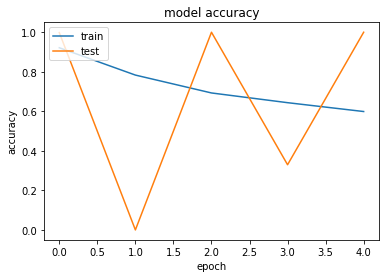

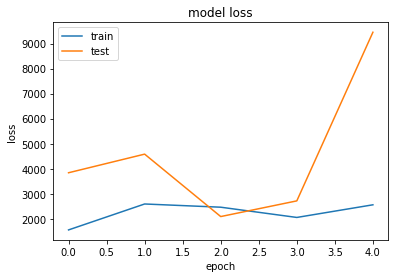

In [25]:
plot_history(history)

In [26]:
result = model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

  ...
    to  
  ['...']
157/157 [==============================] - 3s 19ms/step - loss: nan - categorical_accuracy: 1.0000
Test-set classification accuracy: 100.00%


In [27]:
# New checkpoint callback is set
checkpoint_callbackx = ModelCheckpoint(fine_tuned_checkpoint_path, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

In [28]:
if os.path.exists(fine_tuned_checkpoint_path):
    model.load_weights(fine_tuned_checkpoint_path)
    print("loaded fine tuned checkpoint: {}".format(fine_tuned_chekpoint_path))

In [29]:
# Unfreeze some layers and train a bit more:
#for layer in model.layers[:172]:
#    layer.trainable = False
#for layer in model.layers[172:]:
#    layer.trainable = True
model.trainable = True

In [30]:
model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['categorical_accuracy', top_5_accuracy])

In [32]:
history = model.fit(generator_train,
                    initial_epoch=epochs_top_layers,
                    epochs=epochs_top_layers+epochs_fine_tuning,
                    steps_per_epoch=steps_train,
                    validation_data=generator_validate,
                    shuffle=True,
                    callbacks = [tensorboard_callback, checkpoint_callback, cm_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 625.0 steps, validate for 157 steps
Epoch 1/5
292/625 [=============>................] - ETA: 5:30 - loss: 8435.7974 - categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [ ]:
plot_history(history)

In [ ]:
result = model.evaluate(generator_test, steps=steps_test)
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

In [ ]:
model.save_weights(new_extended_inception_weights)

In [ ]:
print("done")